# Spaceship Titanic

This project is my submission for the [Kaggle Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic) competition. The goal is to build a model that predicts which passengers were transported from the Spaceship Titanic with the greatest possible accuracy. My top score of .8057 ranks in the top 10% of over 2700 competitors.

## 1. Imports and Preliminary Data Review

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
submission_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


There are over 8000 records and not too many null values. Before moving into EDA, I combine the two DataFrames so that I can perform feature engineering on both of them simultaneously. I also prepare to separate them once again after EDA and feature engineering. I create two functions: one to combine the DataFrames and the other to separate them. I use the lengths of each DataFrame to show the separation function where to separate them.

In [6]:
train_df_len = len(train_df)
submission_df_len = len(submission_df)

In [7]:
# This code to combine and separate the train and test DataFrames is adapted from the following YouTube video: 
# https://www.youtube.com/watch?v=Tm70lEXivCg&t=893s

def combine_df(train_df, submission_df):
    combined_df = pd.concat([train_df, submission_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, submission_df_len):
    train_df = combined_df.iloc[:train_df_len]
    submission_df = combined_df.iloc[train_df_len:train_df_len + submission_df_len]
    return train_df, submission_df

full_df = combine_df(train_df, submission_df)
len(full_df)

12970

## 2. EDA and Feature Engineering

### 2a. Home Planet

In [8]:
train_df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

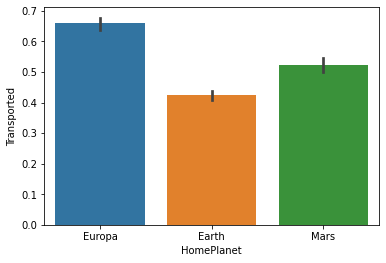

In [9]:
sns.barplot(x='HomePlanet',y='Transported',data=train_df);

Earth has the most passengers, and Europa has the highest rate of transported passengers.

### 2b. CryoSleep

In [10]:
train_df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

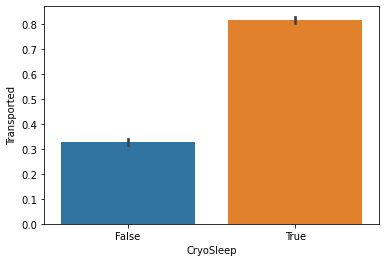

In [11]:
sns.barplot(x='CryoSleep',y='Transported',data=train_df);

Most passengers were not in cryosleep, but those that were were transported at more than double the rate of those that were not.

### 2c. Cabins

In [12]:
train_df['Cabin'].value_counts()

G/734/S     8
C/137/S     7
G/1476/S    7
B/11/S      7
F/1194/P    7
           ..
F/1470/P    1
F/1083/P    1
G/1339/S    1
F/269/P     1
E/477/P     1
Name: Cabin, Length: 6560, dtype: int64

There are too many unique cabins to be useful for modeling. The data dictionary on Kaggle shows that each cabin has a deck, room number, and side separated by commas. Ultimately, I need to separate each cabin into those discrete features. First, I create a new feature based on how many passengers are in each cabin to see whether that has any correlation to whether or not passengers were transported.

In [13]:
cabin_counts = full_df['Cabin'].value_counts()

In [14]:
cabin_df = pd.DataFrame({'cabin' : cabin_counts.index, 'people in cabin' : cabin_counts.values})

In [15]:
cabin_df

,cabin,people in cabin
0,G/734/S,8
1,G/160/P,8
2,E/13/S,7
3,G/1368/P,7
4,G/981/S,7
...,...,...
9820,F/1703/P,1
9821,F/455/P,1
9822,F/1775/S,1
9823,G/1121/P,1


In [16]:
full_df = full_df.merge(cabin_df, left_on = 'Cabin', right_on = 'cabin', how = 'left')

In [17]:
full_df.drop('cabin',axis=1,inplace=True)

In [18]:
# Because each part of the cabin label is separated by a forward slash, 
# I use that to split each string into three separate features.

cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck','Room_Number','Side']
full_df = pd.concat([full_df, cabin_split], axis = 1)
full_df.drop(columns=['Cabin'], inplace = True)
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,people in cabin,Deck,Room_Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1.0,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2.0,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2.0,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1.0,F,1,S


In [19]:
full_df['people in cabin'].value_counts()

1.0    8141
2.0    2066
3.0    1095
4.0     596
5.0     350
6.0     288
7.0     119
8.0      16
Name: people in cabin, dtype: int64

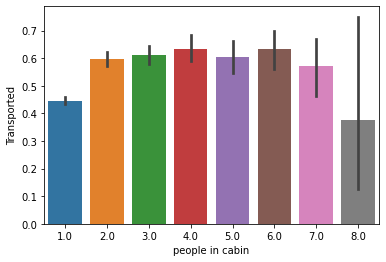

In [20]:
sns.barplot(x='people in cabin',y='Transported',data=full_df);

Most passengers stayed in their own rooms, but many passengers did room together. Those that roomed together were transported at higher rates than those that roomed on their own (only two rooms had 8 passengers, so the sample size is too small to draw firm conclusions about as represented by the large error line in the bar plot). I create a new feature to reflect this trend.

In [21]:
full_df.loc[full_df['people in cabin']==1,'Solo'] = 1
full_df.loc[full_df['people in cabin']!=1,'Solo'] = 0

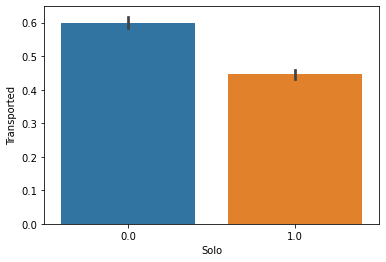

In [22]:
sns.barplot(x='Solo',y='Transported',data=full_df);

In [23]:
full_df['Deck'].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64

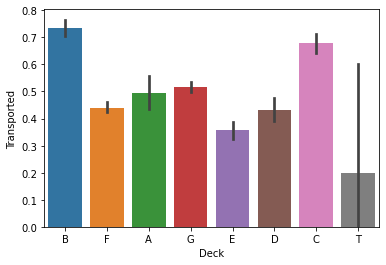

In [24]:
sns.barplot(x='Deck',y='Transported',data=full_df);

Decks B and C have the highest rates of transported passengers. I create a new feature to represent this trend.

In [25]:
full_df.loc[(full_df['Deck']=='B')|(full_df['Deck']=='C'),'DeckGrouped'] = 1
full_df.loc[(full_df['Deck']!='B')&(full_df['Deck']!='C'),'DeckGrouped'] = 0

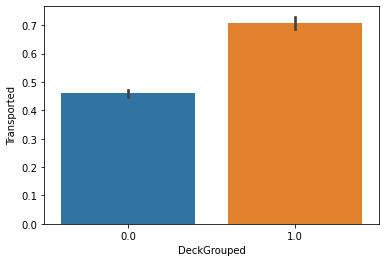

In [26]:
sns.barplot(x='DeckGrouped',y='Transported',data=full_df);

In [27]:
full_df['Room_Number'].value_counts()

82      34
4       28
56      28
31      27
95      27
        ..
1866     1
1861     1
1823     1
1822     1
1810     1
Name: Room_Number, Length: 1894, dtype: int64

In [28]:
full_df['Side'].value_counts()

S    6381
P    6290
Name: Side, dtype: int64

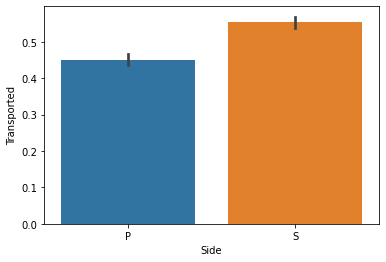

In [29]:
sns.barplot(x='Side',y='Transported',data=full_df);

Side has a minimal correlation with whether or not a passenger was transported.

### 2d. Destination

In [30]:
train_df['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

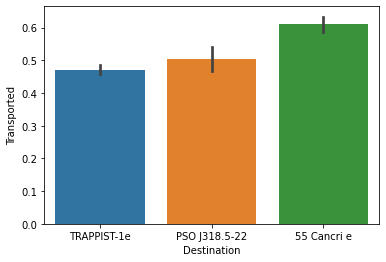

In [31]:
sns.barplot(x='Destination',y='Transported',data=train_df);

Destination has some correlation with whether or not a passenger is transported but only a minimal amount.

### 2e. VIP

In [32]:
train_df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

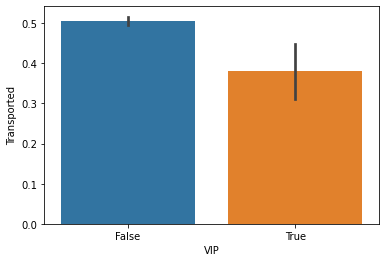

In [33]:
sns.barplot(x='VIP',y='Transported',data=train_df);

There are only about 200 VIPs, so this feature is of limited value. The VIPs are transported at a lower rate, though.

### 2f. Age

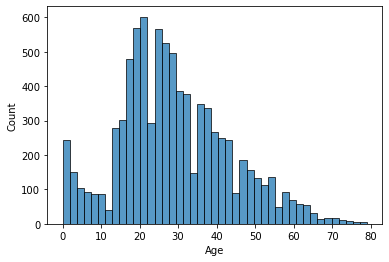

In [34]:
sns.histplot(x='Age',data=train_df);

In [35]:
train_df['Age_bins'] = pd.cut(train_df['Age'],bins=10)

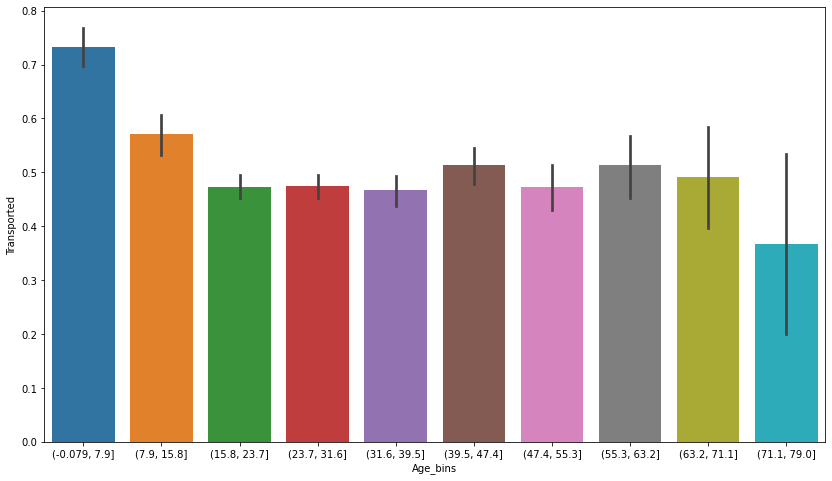

In [36]:
plt.figure(figsize=(14,8))
sns.barplot(x='Age_bins',y='Transported',data=train_df);

Most of the passengers are in their 20s. Binning the age shows that children below 8 years of age are transported more than other age categories, so I create a feature to represent that.

In [37]:
full_df.loc[full_df['Age']<8,'Child'] = 1
full_df.loc[full_df['Age']>=8,'Child'] = 0

### 2g. Amenities

There are 5 features that show how much customers spend at various amenities. The patterns for each of them tend to be similar: most people spend nothing on each amenity but some do. I review each one and then group them to look for trends.

In [38]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


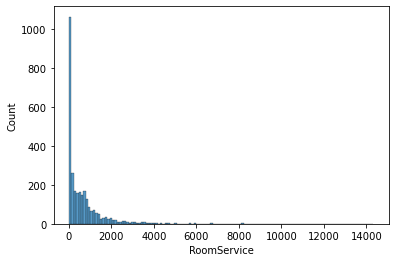

In [39]:
sns.histplot(x='RoomService',data=train_df[train_df['RoomService']!=0]);

In [40]:
full_df.loc[full_df['RoomService']==0,'RoomServiceSpending'] = 0
full_df.loc[full_df['RoomService']!=0,'RoomServiceSpending'] = 1

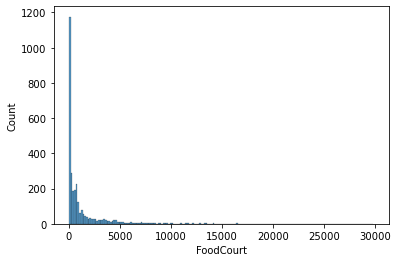

In [41]:
sns.histplot(x='FoodCourt',data=train_df[train_df['FoodCourt']!=0]);

In [42]:
full_df.loc[full_df['FoodCourt']==0,'FoodCourtSpending'] = 0
full_df.loc[full_df['FoodCourt']!=0,'FoodCourtSpending'] = 1

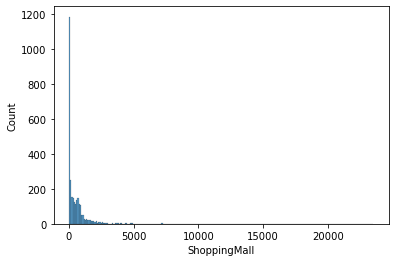

In [43]:
sns.histplot(x='ShoppingMall',data=train_df[train_df['ShoppingMall']!=0]);

In [44]:
full_df.loc[full_df['ShoppingMall']==0,'ShoppingMallSpending'] = 0
full_df.loc[full_df['ShoppingMall']!=0,'ShoppingMallSpending'] = 1

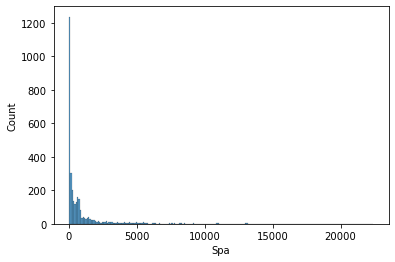

In [45]:
sns.histplot(x='Spa',data=train_df[train_df['Spa']!=0]);

In [46]:
full_df.loc[full_df['Spa'] == 0, 'SpaSpending'] = 0
full_df.loc[full_df['Spa'] != 0, 'SpaSpending'] = 1

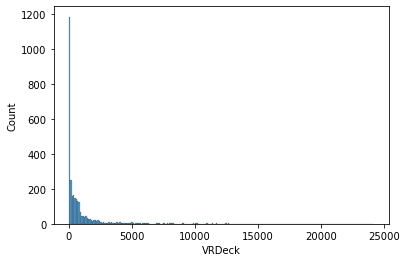

In [47]:
sns.histplot(x='VRDeck',data=train_df[train_df['VRDeck']!=0]);

In [48]:
full_df.loc[full_df['VRDeck'] == 0, 'VRSpending'] = 0
full_df.loc[full_df['VRDeck'] != 0, 'VRSpending'] = 1

In [49]:
full_df['Amenities'] = full_df['VRSpending'] + full_df['SpaSpending'] + full_df['ShoppingMallSpending'] + full_df['FoodCourtSpending'] + full_df['RoomServiceSpending']

In [50]:
full_df['Amenities'].value_counts()

0.0    4858
3.0    3040
4.0    2078
2.0    1677
1.0     872
5.0     445
Name: Amenities, dtype: int64

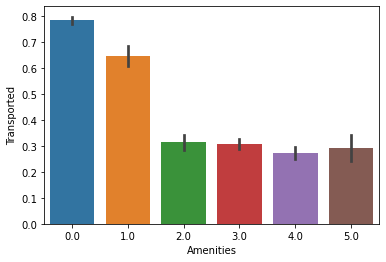

In [51]:
sns.barplot(x='Amenities',y='Transported',data=full_df);

The most common individual outcome is that a passenger does not spend on amenities, but more passengers spend on amenities than do not spend. Passengers who do not spend on amenities are transported at the highest rate, followed by passengers who spend on one amenity, and then passengers who spend on two or more. I create a feature to represent this.

In [52]:
full_df.loc[full_df['Amenities'] == 0, 'AmenityGroup'] = 0
full_df.loc[full_df['Amenities'] == 1, 'AmenityGroup'] = 1
full_df.loc[full_df['Amenities'] >= 2, 'AmenityGroup'] = 2

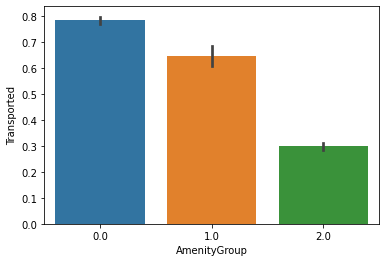

In [53]:
sns.barplot(x='AmenityGroup',y='Transported',data=full_df);

## 3. Preparing for Modeling

While I plan to use a simple imputer to fill most of the null values in the data set, it is likely that most of the passengers who do not spend on amenities are in cryosleep and vice versa. I use this insight to reduce the amount of null values before setting up my pipelines.

In [54]:
full_df.loc[full_df['Amenities']==0,'CryoSleep'] = full_df.loc[full_df['Amenities']==0,'CryoSleep'].fillna(True)
full_df.loc[full_df['Amenities']!=0,'CryoSleep'] = full_df.loc[full_df['Amenities']!=0,'CryoSleep'].fillna(False)

In [55]:
full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']] = full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']].fillna(0)

In [56]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 12969
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           12970 non-null  object 
 1   HomePlanet            12682 non-null  object 
 2   CryoSleep             12970 non-null  object 
 3   Destination           12696 non-null  object 
 4   Age                   12700 non-null  float64
 5   VIP                   12674 non-null  object 
 6   RoomService           12800 non-null  float64
 7   FoodCourt             12790 non-null  float64
 8   ShoppingMall          12795 non-null  float64
 9   Spa                   12793 non-null  float64
 10  VRDeck                12793 non-null  float64
 11  Name                  12676 non-null  object 
 12  Transported           8693 non-null   object 
 13  people in cabin       12671 non-null  float64
 14  Deck                  12671 non-null  object 
 15  Room_Number        

I change the data type for solo, child, and amenitygroup because while they are represented by 1 and 0, I am going to treat them as categorical with one hot encoding.

In [57]:
full_df[['Solo','Child','AmenityGroup']] = full_df[['Solo','Child','AmenityGroup']].astype(object)

Next, I use the function from before to separate the DataFrames back into train and test and then perform a train test split on the train data so that I can evaluate model performance prior to submission.

In [58]:
train_df, submission_df = separate_df(full_df, train_df_len, submission_df_len)

In [59]:
train_df['Transported'] = train_df['Transported'].astype(bool)

<ipython-input-59-11e9fc69bc87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported'] = train_df['Transported'].astype(bool)


In [60]:
X = train_df.drop('Transported',axis=1)
y = train_df['Transported']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = 42)

I identify the columns that I want to include in my models and set up subpipelines and a column transformer.

In [62]:
ohecols = ['HomePlanet','CryoSleep','Destination','VIP','Deck','DeckGrouped','Side','AmenityGroup','Child','Solo']

In [63]:
numcols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [64]:
ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [65]:
num_sub = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [66]:
CT = ColumnTransformer(transformers=[
    ('ohe', ohe_sub, ohecols),
    ('num', num_sub, numcols),   
])

In [67]:
CT_ohe = ColumnTransformer(transformers=[
    ('ohe', ohe_sub, ohecols)
])

## 3. Modeling

I begin the modeling process by creating a dummy classifier to set a baseline. I then iterate through a variety of models to evaluate their performance and experiment with different hyper parameters as I go. I avoid using grid search for timing purposes, but that could be a next step to improve model performance.

### 3a. Dummy

In [68]:
dum_pipe = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [69]:
dum_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [70]:
dum_pipe.score(X_test,y_test)

0.5048878665899943

### 3b. Logistic Regression

In [71]:
lr_pipe = Pipeline([
    ('ct', CT),
    ('lr', LogisticRegression(random_state=42))
])

In [72]:
lr_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('lr', LogisticRegression(random_state=42))])

In [73]:
lr_pipe.score(X_train,y_train)

0.7960885821110153

In [74]:
lr_pipe.score(X_test,y_test)

0.7843588269120184

### 3c. Random Forest

In [75]:
rf_pipe = Pipeline([
    ('ct', CT),
    ('rf', RandomForestClassifier(max_depth = 5, random_state = 42))
])

In [76]:
rf_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('rf', RandomForestClassifier(max_depth=5, random_state=42))])

In [77]:
rf_pipe.score(X_train,y_train)

0.7706356054069601

In [78]:
rf_pipe.score(X_test,y_test)

0.7636572742955722

### 3d. XGBoost

In [79]:
xgb_pipe = Pipeline([
    ('ct',CT),
    ('pf',PolynomialFeatures(degree=2)),
    ('xgb',XGBClassifier(n_estimators = 100, max_depth = 5,
                         min_child_weight= 1, gamma = 5,
                         random_state=42))
])

In [80]:
xgb_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer...
                               colsample_bytree=1, gamma=5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [81]:
xgb_pipe.score(X_train,y_train)

0.8360655737704918

In [82]:
xgb_pipe.score(X_test,y_test)

0.7941345600920069

### 3e. GradientBoosting

In [83]:
gb_pipe = Pipeline([
    ('ct',CT),
    ('gb',GradientBoostingClassifier(loss='exponential', learning_rate = .4, random_state=42))
])

In [84]:
gb_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.4,
                                            loss='exponential',
                                            random_state=42))])

In [85]:
gb_pipe.score(X_train,y_train)

0.8433994823123382

In [86]:
gb_pipe.score(X_test,y_test)

0.7993099482461185

### 3f. ADA Boost

In [87]:
ada_pipe = Pipeline([
    ('ct',CT),
    ('ada',AdaBoostClassifier(random_state=42))
])

In [88]:
ada_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('ada', AdaBoostClassifier(random_state=42))])

In [89]:
ada_pipe.score(X_train,y_train)

0.8008340523439746

In [90]:
ada_pipe.score(X_test,y_test)

0.7832087406555491

### 3g. SVC

In [91]:
svc_pipe = Pipeline([
    ('ct', CT),
    ('svc', SVC(C=2, kernel='poly',random_state=42))
])

In [92]:
svc_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'DeckGrouped', 'Side',
                                                   'AmenityGroup', 'Child',
                                                   'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('svc', SVC(C=2, kernel='poly', random_state=42))])

In [93]:
svc_pipe.score(X_train,y_train)

0.8235547886108714

In [94]:
svc_pipe.score(X_test,y_test)

0.7987349051178838

### 3g. Stacking Classifier

In [95]:
estimator_list = [
    ('xgb', xgb_pipe),
    ('gb', gb_pipe),
    ('svc', svc_pipe)
]

In [96]:
stack_model = StackingClassifier(
    estimators = estimator_list, final_estimator=LogisticRegression(random_state=42)
)

In [97]:
stack_model.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse

StackingClassifier(estimators=[('xgb',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('ohe',
                                                                                  Pipeline(steps=[('cat_impute',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['HomePlanet',
                                                                                   'CryoSleep',
                                                                                   'Destination',
                                                                                   'VIP',
                                                                                   'Deck',
                                                                                   'DeckGrouped',
                                                                                   'Side',
                                                                                   'AmenityGroup',
                                                                                   'Child',
                                                                                   'Solo']),
                                                                                 ('num',
                                                                                  Pipel...
                                                                                  ['HomePlanet',
                                                                                   'CryoSleep',
                                                                                   'Destination',
                                                                                   'VIP',
                                                                                   'Deck',
                                                                                   'DeckGrouped',
                                                                                   'Side',
                                                                                   'AmenityGroup',
                                                                                   'Child',
                                                                                   'Solo']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('num_impute',
                                                                                                   SimpleImputer()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'RoomService',
                                                                                   'FoodCourt',
                                                                                   'ShoppingMall',
                                                                                   'Spa',
                                                                                   'VRDeck'])])),

In [98]:
stack_model.score(X_train,y_train)

0.8403796376186368

In [99]:
stack_model.score(X_test,y_test)

0.7941345600920069

### 3h. Voting Classifier

In [100]:
voting_model = VotingClassifier(
    estimators = estimator_list
)

In [101]:
voting_model.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('ct',
                                               ColumnTransformer(transformers=[('ohe',
                                                                                Pipeline(steps=[('cat_impute',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['HomePlanet',
                                                                                 'CryoSleep',
                                                                                 'Destination',
                                                                                 'VIP',
                                                                                 'Deck',
                                                                                 'DeckGrouped',
                                                                                 'Side',
                                                                                 'AmenityGroup',
                                                                                 'Child',
                                                                                 'Solo']),
                                                                               ('num',
                                                                                Pipelin...
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['HomePlanet',
                                                                                 'CryoSleep',
                                                                                 'Destination',
                                                                                 'VIP',
                                                                                 'Deck',
                                                                                 'DeckGrouped',
                                                                                 'Side',
                                                                                 'AmenityGroup',
                                                                                 'Child',
                                                                                 'Solo']),
                                                                               ('num',
                                                                                Pipeline(steps=[('num_impute',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'RoomService',
                                                                                 'FoodCourt',
                                                                                 'ShoppingMall'

In [102]:
voting_model.score(X_test,y_test)

0.8039102932719954

## 4. Submission

In the end, the model that performs the best on the test data is the voting model using the XGBoost Classifier, Gradient Boosting Classifier, and Support Vector Classifier. I use this model to create my submission, which has an accuracy score of .8057 and places in a large tie for 242 place at the time of submission.

In [103]:
passenger_ids = submission_df['PassengerId']

In [104]:
predictions = voting_model.predict(submission_df).astype(bool)

In [105]:
result_df = pd.DataFrame({'PassengerId':passenger_ids,'Transported':predictions})

In [106]:
result_df.to_csv('submission_7.csv',index=False)